# Análisis exploratorio de datos.

# Primera parte.

Se realizará un análisis exploratorio de datos. Al final del Notebook, se escribirá:

- Una lista de preguntas aclaratorias.
- Un plan aproximado para resolver la tarea, que especifica de 3 a 5 pasos básicos y los explica en uno o dos enunciados

## Paso 0. Importar librerías.

In [1]:
# Standard Library
from scipy.stats import chi2_contingency

# Data Manipulation and Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.tree import DecisionTreeClassifier

# Other ML Libraries
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

# Deep Learning Framework
from tensorflow import keras


## Paso 1. Carga de datos.

In [2]:
df_contract = pd.read_csv("final_provider\contract.csv")
df_internet = pd.read_csv("final_provider\internet.csv")
df_personal = pd.read_csv("final_provider\personal.csv")
df_phone = pd.read_csv("final_provider\phone.csv")

In [3]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [5]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Los datasets se cargaron satisfactoriamente de los cuales son 4 en total. Cada uno proporciona información única del cliente y los servicios que contrató que vamos a explorar a fondo más adelante.

## Paso 2. Información general de los datos.

In [7]:
print("Información general del dataset:\n")
print(df_contract.info())

print("\nInformación general estadística del dataset:\n")
df_contract.describe(include='all')

Información general del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Información general estadística del dataset:



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


El primer dataset (`df_contract`) contiene información sobre el contrato del cliente. Su volumen es de 7,043 registros y 8 campos, de los cuales 1 es de tipo `float64` y 7 son de tipo `object`. No hay valores nulos.

Según la información estadística, en la columna `EndDate`, el 73.46 % de los usuarios siguen siendo clientes de la compañía y continúan disfrutando de sus servicios contratados, mientras que el resto decidió dejar de serlo. Otro punto importante es que, de acuerdo con los datos de la columna `MonthlyCharges`, la desviación estándar es de 30.090, con un valor mínimo de 18.25 y un máximo de 118.75. Además, los datos están sesgados a la izquierda, ya que el promedio es menor que la mediana.


In [8]:
print("Información general del dataset:\n")
df_internet.info()

print("\nInformación general estadística del dataset:\n")
df_internet.describe(include='all')

Información general del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Información general estadística del dataset:



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


El segundo dataset contiene información sobre los servicios de internet contratados por los clientes, como el servicio de teléfono fijo, internet, antivirus, etc. Tiene un volumen de 5,517 registros y 8 columnas, todas de tipo `object`, y no presenta valores nulos.

Los valores parecen ser de tipo booleano, ya que solo representan si el cliente cuenta o no con un servicio específico. La mayoría de los usuarios optan por tener software de antivirus y un plan de soporte técnico, además del servicio de internet. Cabe mencionar que únicamente se dispone de información relevante para 5,517 de los 7,043 usuarios registrados en el dataset de contratos.

In [9]:
print("Información general del dataset:\n")
df_personal.info()

print("\nInformación general estadística del dataset:\n")
df_personal.describe(include='all')

Información general del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Información general estadística del dataset:



,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


El tercer dataset proporciona información de datos personales del cliente. Contiene 7,043 registros y 5 columnas. Los tipos de datos incluyen una columna de tipo `int64` y el resto son de tipo `object`. No hay valores nulos, y el número de registros coincide con el del primer dataset.

De acuerdo con la información estadística, la cantidad de hombres y mujeres registrada en este dataset es aproximadamente proporcional, aunque hay ligeramente más hombres que mujeres. Por otro lado, en la columna `SeniorCitizen`, se observa que la mayoría de las personas no pertenecen al grupo de la tercera edad. En cuanto a las columnas `Partner` y `Dependents`, aún no se tiene información relevante sobre el tipo de datos que contienen.

In [10]:
print("Información general del dataset:\n")
df_phone.info()

print("\nInformación general estadística del dataset:\n")
df_phone.describe(include='all')

Información general del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Información general estadística del dataset:



,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


El dataset contiene información sobre los servicios telefónicos; por ejemplo, si el cliente tiene más de una línea de teléfono fijo. Cuenta con 6,361 registros y dos columnas, cuyos tipos de datos son `object`, y no tiene valores nulos.

El método `describe` no proporciona mucha información al respecto, solo que el 53 % de los 6,362 usuarios tiene solo una línea de teléfono fijo.

### Conclusión de este paso.

El análisis preliminar de los datasets proporciona información clave sobre los patrones de comportamiento y las preferencias de los clientes de la compañía.

- **Dataset de contratos**: Este dataset muestra que el 73.46 % de los clientes sigue activo, lo cual refleja una buena tasa de retención. La distribución de los cargos mensuales muestra un sesgo a la izquierda, lo que implica que la mayoría de los clientes opta por planes más costosos, mientras que solo una minoría está en planes económicos. La desviación estándar de 30.090 sugiere una variabilidad considerable en los montos cobrados mensualmente, probablemente debido a distintos niveles de servicio o paquetes contratados.

- **Dataset de servicios de internet**: Los datos indican que la mayoría de los clientes contratan servicios adicionales, como antivirus y soporte técnico, reflejando una preferencia por los servicios de valor añadido. Sin embargo, solo se dispone de información de servicios de internet para 5,517 de los 7,043 clientes en el dataset de contratos, lo cual sugiere que cerca del 21.6 % de los clientes no tienen servicios de internet contratados o que faltan datos en este aspecto.

- **Dataset de datos personales**: La proporción entre hombres y mujeres es casi igual, con una ligera mayoría de hombres. Además, la mayoría de los clientes no pertenece al grupo de la tercera edad, lo cual podría influir en sus preferencias de servicios. Variables como "Partner" y "Dependents" podrían ser relevantes para un análisis más detallado que explore cómo impactan el uso de servicios.

- **Dataset de servicios telefónicos**: Aproximadamente el 53 % de los clientes con servicios telefónicos tiene una sola línea de teléfono fijo, lo que indica una preferencia general por una configuración más sencilla. Sin embargo, una proporción significativa de usuarios cuenta con varias líneas, lo que podría estar relacionado con hogares más grandes o mayores necesidades de comunicación.

En resumen, estos datos sugieren que la mayoría de los clientes prefieren mantener servicios básicos y planes de costos más altos, mientras que un grupo importante contrata servicios adicionales como antivirus o soporte técnico. Además, la mayoría de los clientes no son personas de la tercera edad, lo cual podría influir en la estrategia de marketing y en la personalización de servicios para distintos perfiles de clientes. La compañía podría explorar oportunidades de ventas adicionales para clientes interesados en servicios más completos, a la vez que continúa sus esfuerzos de retención para los clientes de planes de menor costo.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a><br>
<b>Éxito</b> - ¡Felicitaciones por incluir conclusiones intermedias en su proyecto! Esto es una práctica excelente ya que ayuda a comprender mejor los datos y a tomar decisiones informadas en la siguiente etapa del análisis. Continúa haciendo esto en futuros proyectos.</div>

## Paso 3. Visualización de los datos.

Hacer gráficas de:
- Agrupar los usuarios por el tipo de subscipción (`Type`)
- Que usuarios tienen todos los servicios contratados, que tipo de 
  subcripción tienen, y que método de pago implementan. Juntar df_contract y df_internet.
- Hacer un scatter matrix de los 3 primeros dataframes.

In [11]:
# Cmabiar a 'Yes' todo lo que no sea 'No'.
df_contract['EndDate'] = \
    df_contract['EndDate'].where(~(df_contract['EndDate'] != 'No'),
                                 'Yes')

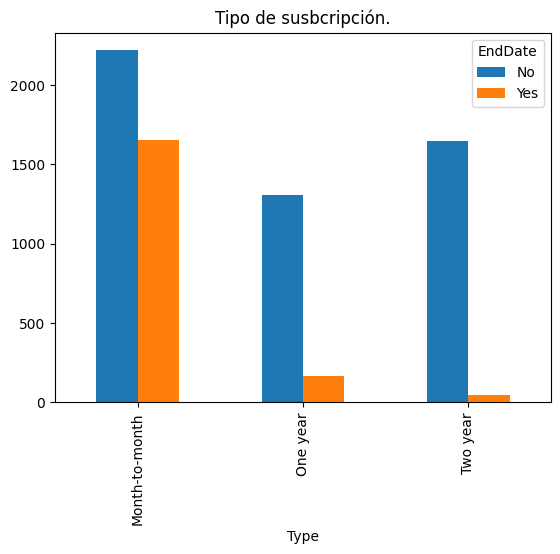

In [12]:
pd.pivot_table(df_contract,
               values = 'customerID',
               index = 'Type',
               columns=['EndDate'],
               aggfunc='count').plot(kind='bar',
                                     title='Tipo de susbcripción.')
plt.show()

De acuerdo con la gráfica los usuarios con suscripción mensual suelen ya no usar los servicios la compañia comparado con los que pagan un año o dos.
Los usuarios con plan mensual suelen canclear los serviicios a comparación con los del plan de un año y dos años

In [13]:
df_contract_internet = pd.merge(df_contract,df_internet,on=['customerID'])
df_contract_internet.head()
#columns = ['InternetService','OnlineSecurity','TechSupport','EndDate']


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No


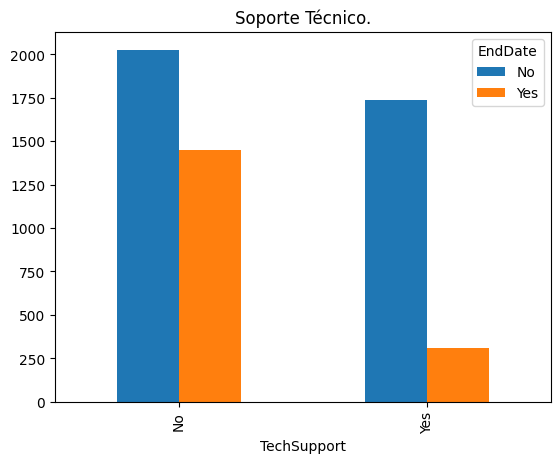

In [14]:
pd.pivot_table(df_contract_internet, values='customerID', index=['TechSupport'], columns=['EndDate'], aggfunc='count').plot(kind='bar',
                                                                                                                            title='Soporte Técnico.')
plt.show()

En al gráfica nos muetras que los usuarios que no tienen plan de soporte técnico son más propensos en irse.

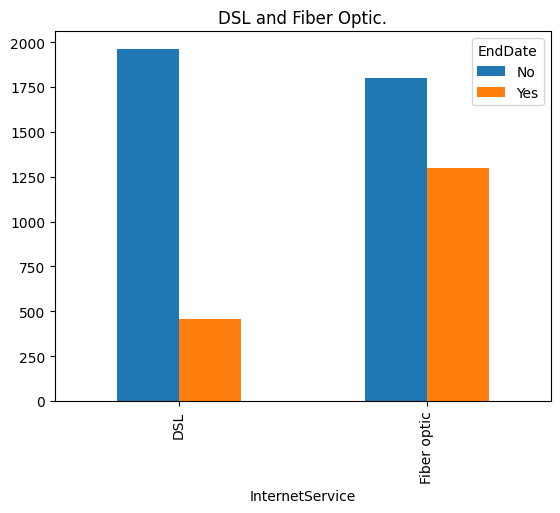

In [15]:
pd.pivot_table(df_contract_internet, values='customerID', index=['InternetService'], columns=['EndDate'], aggfunc='count').plot(kind='bar',
                                                                                                                            title='DSL and Fiber Optic.')
plt.show()

Curioso que los usuarios con fibra óptica tienden a abandonar la compañía.

In [16]:
# cambiar a int64 los valores de las columna TotalCharges
df_contract_internet['TotalCharges'] = df_contract_internet['TotalCharges']\
    .where(~(df_contract_internet['TotalCharges'] == ' '), 0) # Tienen cadenas vacías como valores.


df_contract_internet['TotalCharges'] = df_contract_internet['TotalCharges'].astype('float64')

In [17]:
df_cont_int_per = pd.merge(df_contract_internet,df_personal,on='customerID')
df_cont_int_per_phone = pd.merge(df_cont_int_per,df_phone,on='customerID')

In [18]:
df_cont_int_per_phone.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
1,3668-QPYBK,2019-10-01,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
2,9237-HQITU,2019-09-01,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
3,9305-CDSKC,2019-03-01,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,No,No,Yes
4,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,Yes,No,No,Yes,No,Male,0,No,Yes,Yes


In [19]:
df_cont_int_per_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   float64
 8   InternetService   4835 non-null   object 
 9   OnlineSecurity    4835 non-null   object 
 10  OnlineBackup      4835 non-null   object 
 11  DeviceProtection  4835 non-null   object 
 12  TechSupport       4835 non-null   object 
 13  StreamingTV       4835 non-null   object 
 14  StreamingMovies   4835 non-null   object 
 15  gender            4835 non-null   object 
 16  SeniorCitizen     4835 non-null   int64  


Las columnas que puedo transformar a valor numérico:
- EndDate, PaperlessBilling, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, gender, Partner, Dependents, MultipleLines

In [20]:
map_y_n = {'Yes':1,'No':0}
columns_to_map = ['EndDate','PaperlessBilling','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Partner','Dependents', 'MultipleLines']
for column in columns_to_map:
    df_cont_int_per_phone[column] = df_cont_int_per_phone[column].map(map_y_n)

In [21]:
df_cont_int_per_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   int64  
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   int64  
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   float64
 8   InternetService   4835 non-null   object 
 9   OnlineSecurity    4835 non-null   int64  
 10  OnlineBackup      4835 non-null   int64  
 11  DeviceProtection  4835 non-null   int64  
 12  TechSupport       4835 non-null   int64  
 13  StreamingTV       4835 non-null   int64  
 14  StreamingMovies   4835 non-null   int64  
 15  gender            4835 non-null   object 
 16  SeniorCitizen     4835 non-null   int64  


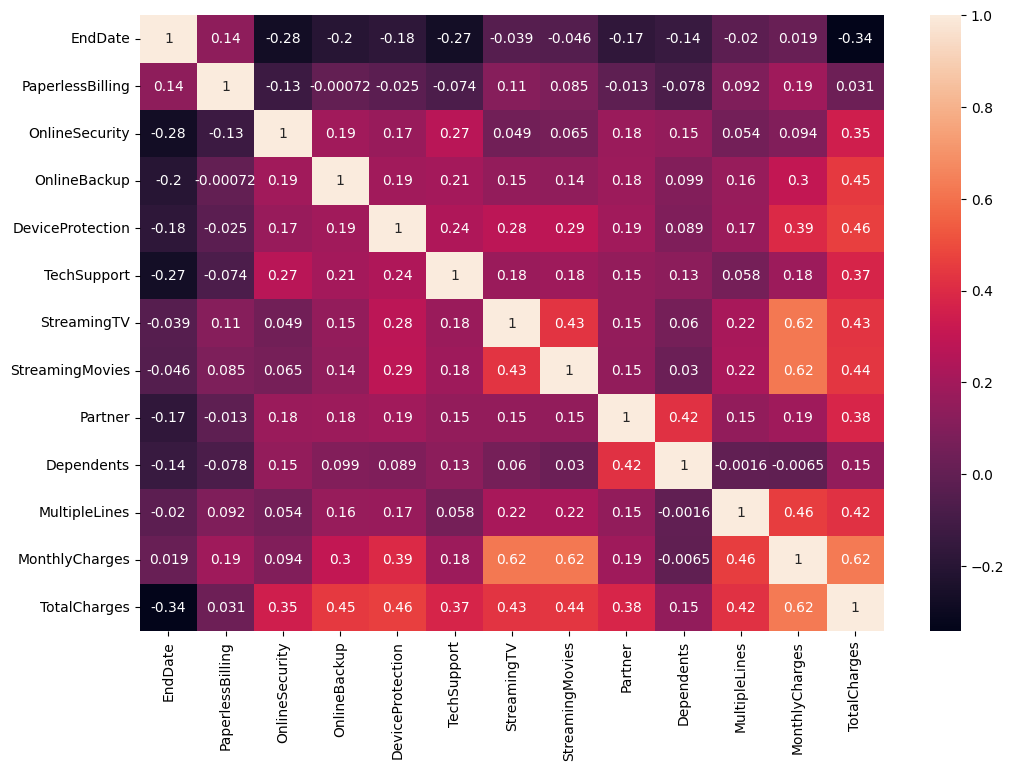

In [22]:
col_corr = ['EndDate','PaperlessBilling','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Partner','Dependents',
                  'MultipleLines','MonthlyCharges','TotalCharges']
plt.figure(figsize=(12,8))
sns.heatmap(df_cont_int_per_phone[col_corr].corr(), annot=True)
plt.show()

En la gráfica de correlación observamos que las columnas que más relación tienen entre otras son `MonthlyCharges` y `StreamingTV`, `StreamingMovies` y `MonthlyCharges`, y `MonthlyCharges` y `TotalCharges` con 0.62 de correlacion.

Vamos a aplicar diferentes metodos de correlación ya que en el dataset `df_cont_int_per_phone` contamos con diferentes tipos de vairbales.

En el dataset se encuentran:
- 12 columnas de carácter de tipo booleano.
- 2 columnas de tipo continuo.
- 5 o 6 columnas con variables de tipo nominal.

Dejamos fuera la característica de fecha ya que es una serie temporal y en este tipo de trabajo no es necesario.

### Correlación de Matthews para variables binarias.

In [23]:
def mcc_matrix(data):
    
    mcc_matrix = np.zeros((data.shape[1], data.shape[1]))
    
    for i in range(data.shape[1]):
        for j in range(i, data.shape[1]):
            mcc_value = matthews_corrcoef(data.iloc[:, i], data.iloc[:, j])
            mcc_matrix[i, j] = mcc_value
            mcc_matrix[j, i] = mcc_value
    
    return pd.DataFrame(mcc_matrix, index=data.columns, columns=data.columns)
    

In [24]:
binary_data = df_cont_int_per_phone[['EndDate','PaperlessBilling',
                                     'OnlineSecurity','OnlineBackup',
                                     'DeviceProtection','TechSupport',
                                     'StreamingTV','StreamingMovies','SeniorCitizen',
                                     'Partner','Dependents','MultipleLines']]

mcc_matrix = np.zeros((binary_data.shape[1], binary_data.shape[1]))

for i in range(binary_data.shape[1]):
    for j in range(i, binary_data.shape[1]):
        mcc_value = matthews_corrcoef(binary_data.iloc[:, i], binary_data.iloc[:, j])
        mcc_matrix[i, j] = mcc_value
        mcc_matrix[j, i] = mcc_value

mcc_df = pd.DataFrame(mcc_matrix, index=binary_data.columns, columns=binary_data.columns)

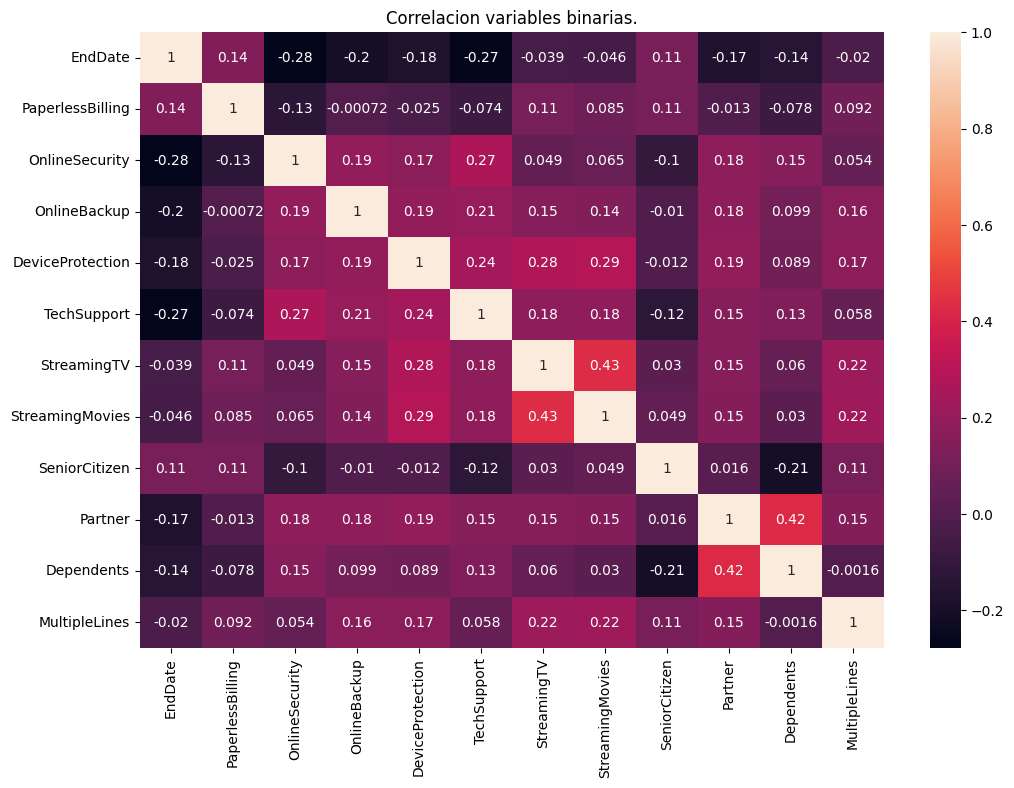

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(mcc_df,annot=True)
plt.title("Correlacion variables binarias.")
plt.show()

De acuerdo a nuestra matrix de correlación de Matthews la columnas `EndDate` tiene una correlación negativa con `TechSupport` y `OnlineSecurity` de -0.27 y 0-.28 respectivamente. Continunado con esas características, las columnas `OnlineSecurity` y `TechSupport` tienen una correlación de 0.27. Dicho lo anterior, los usuarios que no tengan plan de servicio técnico y porgrama especializado en ciberseguridad probabblemente dejen la compañía.

Las correlaciones mas altas fueron `StreamingTV` con `StreamingMovies` con 0.43 y `Partner` y `Dependentes` con 0.42; aunque aún no sabemos a que se refieron estas dos variables. El streaming de TV y películas no parecen ser uan característica importante para predecir si el usuario seguirá en la consumiendo los servicios; no bostnate, ver la correlación fue punto clave para ofrecer estos servicios a un precio especial a los clientes potenciales de dejar la compañía.

### Correlación de Pearson para variables continuas.

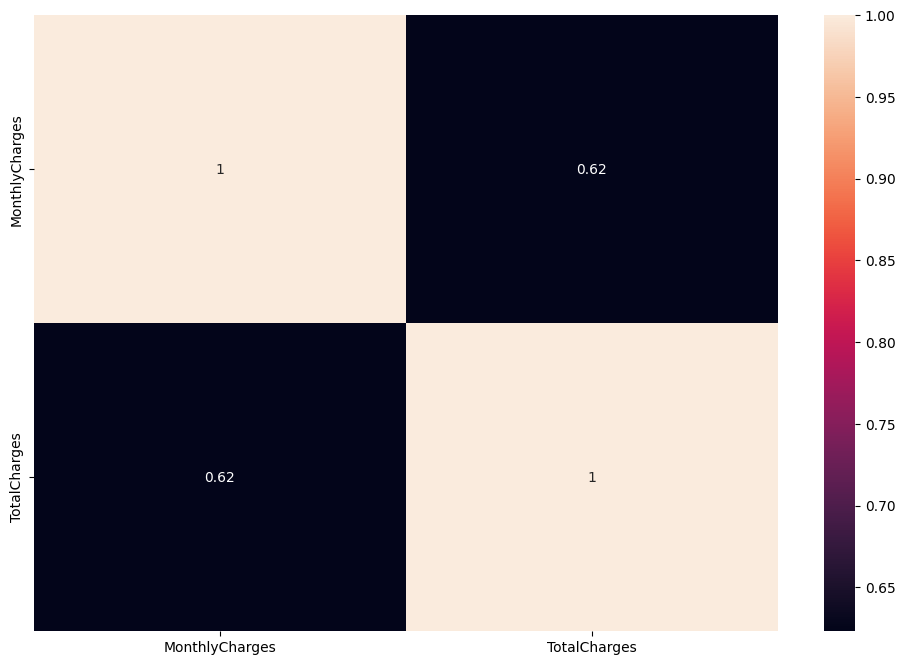

In [26]:
plt.figure(figsize=(12,8))
sns.heatmap(df_cont_int_per_phone[['MonthlyCharges','TotalCharges']].corr(),annot=True)
plt.show()

`MonthlyCharges` y `TotalCharges` tienen una correlación alta-moderado. Pueden ser características importantes para la predicción.

### Correlación Chi cuadrada para vairbales nominales.

In [27]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

def cramers_v_matrix(df):
    cols = df.columns
    n_cols = len(cols)
    result = pd.DataFrame(np.zeros((n_cols, n_cols)), columns=cols, index=cols)

    for i in range(n_cols):
        for j in range(i, n_cols):
            if i == j:
                result.iloc[i, j] = 1.0
            else:
                result.iloc[i, j] = cramers_v(df.iloc[:, i], df.iloc[:, j])
                result.iloc[j, i] = result.iloc[i, j]

    return result

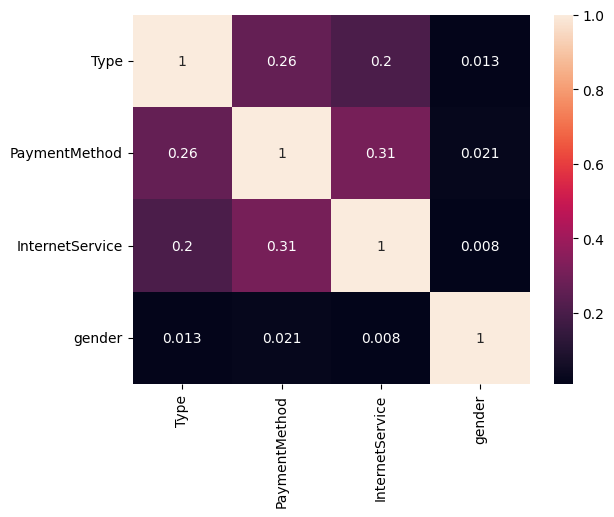

In [28]:
sns.heatmap(cramers_v_matrix(df_cont_int_per_phone[['Type','PaymentMethod','InternetService','gender']]),
            annot=True)
plt.show()

Com ya vimos en gráficas anteriroes el tipo de subcripción si está correlacionada con si el cliente puede irse o no, tenioendo una correlación de 0.39. Por lo tento la caracterísitica `Type` puede ser cracterística que ayude a la predección.

Podemos llegar a la conclsuión de que la cacracterísticas mas importantes para predecir la fuga de un cliente son `TechSupport`, `OnlineSecurity`, `Type`, `TotalCharges`, `MonthlyCharges`.

### Conclusión de este paso.

Para concluir este análisis, observamos algunos patrones clave en el comportamiento de los usuarios y las correlaciones entre diversas características de suscripción y el abandono del servicio.

Primero, los usuarios con suscripciones mensuales tienden a dejar el servicio con más frecuencia que aquellos que optan por planes de uno o dos años, lo que indica que el compromiso a largo plazo podría ser un factor relevante en la retención de clientes. Además, los clientes que no cuentan con un plan de soporte técnico o servicio de ciberseguridad son más propensos a abandonar la compañía. De hecho, las correlaciones de Matthews muestran que las variables TechSupport y OnlineSecurity presentan correlaciones negativas con la columna EndDate, sugiriendo que estos servicios pueden ser determinantes en la decisión de continuar o cancelar la suscripción.

Por otro lado, la correlación entre StreamingTV y StreamingMovies (0.43) y entre Partner y Dependents (0.42) indica una posible afinidad en el uso de servicios de entretenimiento y una relación entre variables familiares; sin embargo, estas no parecen estar directamente vinculadas con la retención de clientes. En contraste, MonthlyCharges y TotalCharges muestran una correlación alta-moderada, lo que sugiere que estos valores pueden ser factores importantes para predecir la permanencia de los usuarios.

Finalmente, con una correlación de 0.39, la variable Type de suscripción se confirma como relevante en el análisis de fuga de clientes. En conclusión, las características TechSupport, OnlineSecurity, Type, TotalCharges y MonthlyCharges se identifican como las variables más importantes para predecir el riesgo de abandono, brindando una base sólida para implementar estrategias de retención orientadas a reforzar estos aspectos entre los clientes actuales y potenciales; sin embargo podemos aplicar otro método de selección de características para incluir todas las necesarias para tener una métrica de accuracy y AUC ROC alta.

# Segunda parte.

## Paso 4. Codificación y escalamiento de los datos.

In [29]:
df_cont_int_per_phone

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,5575-GNVDE,2017-04-01,0,One year,0,Mailed check,56.95,1889.50,DSL,1,0,1,0,0,0,Male,0,0,0,0
1,3668-QPYBK,2019-10-01,1,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,0,0,0,0,Male,0,0,0,0
2,9237-HQITU,2019-09-01,1,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,0,0,0,0,0,Female,0,0,0,0
3,9305-CDSKC,2019-03-01,1,Month-to-month,1,Electronic check,99.65,820.50,Fiber optic,0,0,1,0,1,1,Female,0,0,0,1
4,1452-KIOVK,2018-04-01,0,Month-to-month,1,Credit card (automatic),89.10,1949.40,Fiber optic,0,1,0,0,1,0,Male,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,2018-07-01,0,Month-to-month,1,Bank transfer (automatic),78.70,1495.10,Fiber optic,0,0,0,0,1,0,Male,0,0,0,0
4831,6840-RESVB,2018-02-01,0,One year,1,Mailed check,84.80,1990.50,DSL,1,0,1,1,1,1,Male,0,1,1,1
4832,2234-XADUH,2014-02-01,0,One year,1,Credit card (automatic),103.20,7362.90,Fiber optic,0,1,1,0,1,1,Female,0,1,1,1
4833,8361-LTMKD,2019-07-01,1,Month-to-month,1,Mailed check,74.40,306.60,Fiber optic,0,0,0,0,0,0,Male,1,1,0,1


In [30]:
definitive_df = df_cont_int_per_phone[['EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines']].copy()

In [31]:
definitive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EndDate           4835 non-null   int64  
 1   Type              4835 non-null   object 
 2   PaperlessBilling  4835 non-null   int64  
 3   PaymentMethod     4835 non-null   object 
 4   MonthlyCharges    4835 non-null   float64
 5   TotalCharges      4835 non-null   float64
 6   InternetService   4835 non-null   object 
 7   OnlineSecurity    4835 non-null   int64  
 8   OnlineBackup      4835 non-null   int64  
 9   DeviceProtection  4835 non-null   int64  
 10  TechSupport       4835 non-null   int64  
 11  StreamingTV       4835 non-null   int64  
 12  StreamingMovies   4835 non-null   int64  
 13  gender            4835 non-null   object 
 14  SeniorCitizen     4835 non-null   int64  
 15  Partner           4835 non-null   int64  
 16  Dependents        4835 non-null   int64  


In [32]:
definitive_df

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0,One year,0,Mailed check,56.95,1889.50,DSL,1,0,1,0,0,0,Male,0,0,0,0
1,1,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,0,0,0,0,Male,0,0,0,0
2,1,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,0,0,0,0,0,Female,0,0,0,0
3,1,Month-to-month,1,Electronic check,99.65,820.50,Fiber optic,0,0,1,0,1,1,Female,0,0,0,1
4,0,Month-to-month,1,Credit card (automatic),89.10,1949.40,Fiber optic,0,1,0,0,1,0,Male,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,0,Month-to-month,1,Bank transfer (automatic),78.70,1495.10,Fiber optic,0,0,0,0,1,0,Male,0,0,0,0
4831,0,One year,1,Mailed check,84.80,1990.50,DSL,1,0,1,1,1,1,Male,0,1,1,1
4832,0,One year,1,Credit card (automatic),103.20,7362.90,Fiber optic,0,1,1,0,1,1,Female,0,1,1,1
4833,1,Month-to-month,1,Mailed check,74.40,306.60,Fiber optic,0,0,0,0,0,0,Male,1,1,0,1


In [33]:
encoder = LabelEncoder()
definitive_df['Type'] = encoder.fit_transform(definitive_df['Type'])
definitive_df['PaymentMethod'] = encoder.fit_transform(definitive_df['PaymentMethod']) 
definitive_df['InternetService'] = encoder.fit_transform(definitive_df['InternetService'])
definitive_df['gender'] = encoder.fit_transform(definitive_df['gender'])

In [34]:
definitive_df.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0,1,0,3,56.95,1889.50,0,1,0,1,0,0,0,1,0,0,0,0
1,1,0,1,3,53.85,108.15,0,1,1,0,0,0,0,1,0,0,0,0
2,1,0,1,2,70.70,151.65,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,2,99.65,820.50,1,0,0,1,0,1,1,0,0,0,0,1
4,0,0,1,1,89.10,1949.40,1,0,1,0,0,1,0,1,0,0,1,1


In [35]:
X = definitive_df.drop(columns=['EndDate'])
y = definitive_df[['EndDate']]

In [36]:
X

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,1,0,3,56.95,1889.50,0,1,0,1,0,0,0,1,0,0,0,0
1,0,1,3,53.85,108.15,0,1,1,0,0,0,0,1,0,0,0,0
2,0,1,2,70.70,151.65,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,2,99.65,820.50,1,0,0,1,0,1,1,0,0,0,0,1
4,0,1,1,89.10,1949.40,1,0,1,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,0,1,0,78.70,1495.10,1,0,0,0,0,1,0,1,0,0,0,0
4831,1,1,3,84.80,1990.50,0,1,0,1,1,1,1,1,0,1,1,1
4832,1,1,1,103.20,7362.90,1,0,1,1,0,1,1,0,0,1,1,1
4833,0,1,3,74.40,306.60,1,0,0,0,0,0,0,1,1,1,0,1


In [37]:
y

,EndDate
0,0
1,1
2,1
3,1
4,0
...,...
4830,0
4831,0
4832,0
4833,1


In [38]:
scaler = Normalizer()
scaler_data = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=scaler_data,columns=X.columns)
X_scaled

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0.000529,0.000000,0.001587,0.030127,0.999544,0.000000,0.000529,0.000000,0.000529,0.000000,0.000000,0.000000,0.000529,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.008273,0.024820,0.445525,0.894773,0.000000,0.008273,0.008273,0.000000,0.000000,0.000000,0.000000,0.008273,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.005976,0.011952,0.422497,0.906246,0.005976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.001210,0.002420,0.120564,0.992698,0.001210,0.000000,0.000000,0.001210,0.000000,0.001210,0.001210,0.000000,0.000000,0.000000,0.000000,0.001210
4,0.000000,0.000512,0.000512,0.045659,0.998956,0.000512,0.000000,0.000512,0.000000,0.000000,0.000512,0.000000,0.000512,0.000000,0.000000,0.000512,0.000512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,0.000000,0.000668,0.000000,0.052566,0.998617,0.000668,0.000000,0.000000,0.000000,0.000000,0.000668,0.000000,0.000668,0.000000,0.000000,0.000000,0.000000
4831,0.000502,0.000502,0.001506,0.042564,0.999091,0.000000,0.000502,0.000000,0.000502,0.000502,0.000502,0.000502,0.000502,0.000000,0.000502,0.000502,0.000502
4832,0.000136,0.000136,0.000136,0.014015,0.999902,0.000136,0.000000,0.000136,0.000136,0.000000,0.000136,0.000136,0.000000,0.000000,0.000136,0.000136,0.000136
4833,0.000000,0.003169,0.009508,0.235800,0.971724,0.003169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003169,0.003169,0.003169,0.000000,0.003169


## Paso 5. Selección de características por otros métodos.

### SelectKBest

In [39]:
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)

selected_features = X_scaled.columns[selector.get_support(indices=True)]
print(f"Características más importantes:\n {selected_features}")

Características más importantes:
 Index(['PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'InternetService', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'MultipleLines'],
      dtype='object')


d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Aplicando el método de SelectKBest, las características más importantes obtenidas por el hierparámetro k=10 fueron 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'InternetService', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'MultipleLines'.

### Random Forest

In [40]:
model = RandomForestClassifier(random_state=0)
model.fit(X_scaled, y)

importances = model.feature_importances_
important_features = X_scaled.columns[importances > 0.05]

print(f"Características más importantes:\n {important_features}")

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Características más importantes:
 Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'gender', 'MultipleLines'],
      dtype='object')


### Lasso

In [41]:

lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y)

selected_features = X_scaled.columns[lasso.coef_ != 0]
print(f"Características más importantes:\n {important_features}")

Características más importantes:
 Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'gender', 'MultipleLines'],
      dtype='object')


En los métodos Random Forest y Lasso. Coincidieron en la selección de las mismas características que fueron 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'gender', 'MultipleLines''. Por lo taanto estas son las caracetrícas que mejor podrían predecir la fuga de un cliente.

## Paso 6. Dividir los datos en conjunto de entreanmiento (67%), prueba (22%) y validación (11%)

In [42]:
X = X_scaled[['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'gender', 'MultipleLines']].copy()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=1234)
X_test, X_valid, y_test,  y_valid = train_test_split(X_test, y_test,test_size=0.33)


print(f"Dataset de entrenamiento:\n")
print(X_train.shape)
print(y_train.shape)

print("\nDataset de prueba:\n")
print(X_test.shape)
print(y_test.shape)

print("\nDataset de prueba:\n")
print(X_valid.shape)
print(y_valid.shape)

Dataset de entrenamiento:

(3239, 8)
(3239, 1)

Dataset de prueba:

(1069, 8)
(1069, 1)

Dataset de prueba:

(527, 8)
(527, 1)


### Conclusion de esta parte.

En conclusión, al aplicar el método SelectKBest con k=10, así como los modelos de Random Forest y Lasso, se identificaron características clave que podrían tener una fuerte influencia en la predicción de la fuga de clientes. Las características que se repitieron en los tres métodos fueron: 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService', 'gender' y 'MultipleLines'.

Esta coincidencia entre los métodos respalda la importancia de estas variables y sugiere que podrían desempeñar un papel fundamental en la predicción de la retención de clientes. Por lo tanto, estas características deberían considerarse prioritarias al desarrollar modelos predictivos de fuga, ya que probablemente contienen la mayor cantidad de información relevante para este objetivo.

# Tercea parte.

## Paso 7. Aplicación de Modelos de Clasificación.

### Regresión Logística.

In [44]:
model = LogisticRegression()
model.fit(X_train,y_train)

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [45]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_valid = model.predict(X_valid)

In [46]:
print(f"Accuracy Entrenamiento: {accuracy_score(y_train,y_pred_train)}")
print(f"Accuracy Prueba: {accuracy_score(y_test,y_pred_test)}")
print(f"Accuracy Validación: {accuracy_score(y_valid, y_pred_valid)}\n")

print(f"ROC AUC score entrenamiento: {roc_auc_score(y_train,y_pred_train)}")
print(f"ROC AUC score prueba: {roc_auc_score(y_test,y_pred_test)}")
print(f"ROC AUC score validación: {roc_auc_score(y_valid, y_pred_valid)}")

Accuracy Entrenamiento: 0.7138005557270762
Accuracy Prueba: 0.7221702525724977
Accuracy Validación: 0.7248576850094877

ROC AUC score entrenamiento: 0.5973247821310557
ROC AUC score prueba: 0.6159170777061632
ROC AUC score validación: 0.6248947811447811


Empezando con regresión logística. Se obtuvo, en el conjugnto de entrenameinto, un accuracy de 0.7138 y en ROC AUC 0.59. A pesar de ser de que el modelo sabía las respuestas de este conjunto, no le fue bastante bien. Por otr lado en el conjunto de prueba le fue mejor en ambos, con un accuracy de 0.7343 y un AUC ROC DE 0.62768. Y en el conjunto de validación 0.70001 y 0.60121, respectivamente. En general al primero modelo no le fue bastante bien; sin embargo estamos analizando el primer de cinco modelos.

In [47]:
def confussion_matrix_multiplot():
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, cmap='Blues', fmt='g', ax=axes[0])
    axes[0].set_title("Matriz de confusión - Entrenamiento")
    axes[0].set_xlabel("Predicción")
    axes[0].set_ylabel("Valor real")
    
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap='Blues', fmt='g', ax=axes[1])
    axes[1].set_title("Matriz de confusión - Prueba")
    axes[1].set_xlabel("Predicción")
    axes[1].set_ylabel("Valor real")

    sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, cmap='Blues', fmt='g', ax=axes[2])
    axes[2].set_title("Matriz de confusión - Validación")
    axes[2].set_xlabel("Predicción")
    axes[2].set_ylabel("Valor real")
    
    plt.show()

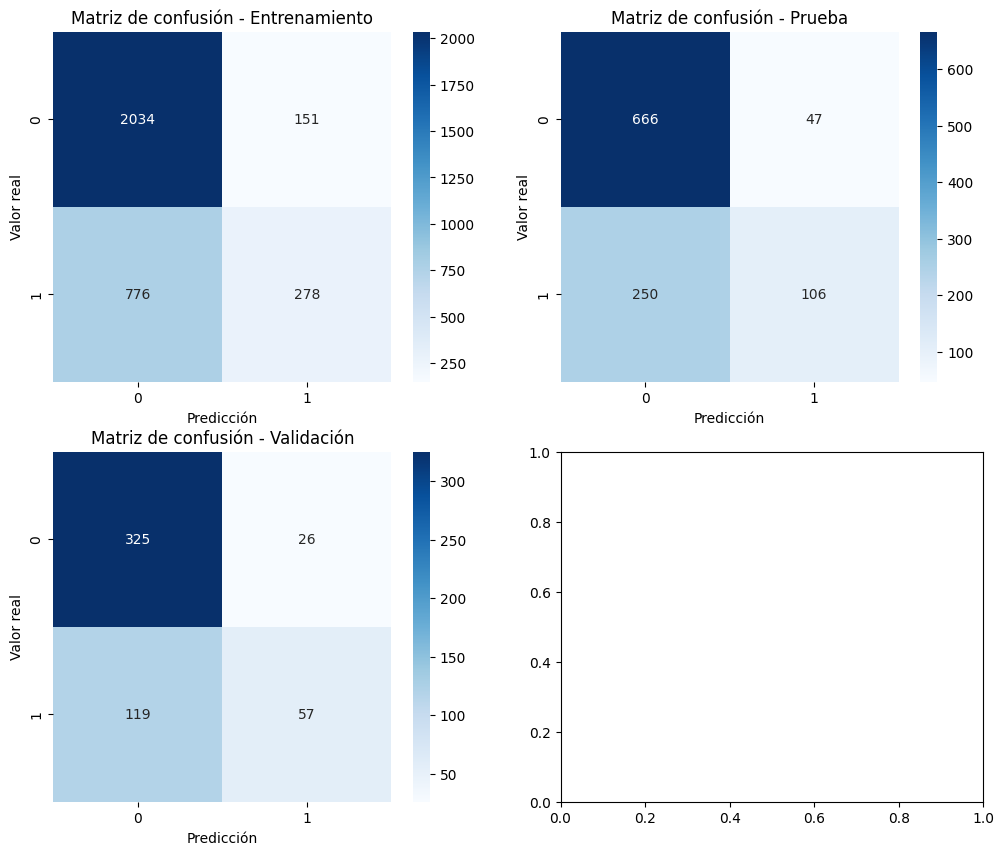

In [48]:
confussion_matrix_multiplot()

### Regresión Logística con validación cruzada.

In [49]:
model = LogisticRegression()

accuracy_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(accuracy_score))
auc_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True))

print("Accuracy promedio:", accuracy_scores.mean())
print("AUC-ROC promedio:", auc_scores.mean())

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECO

Accuracy promedio: 0.7176835573940021
AUC-ROC promedio: 0.7548870601752764


d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECO

Con validación cruzada nuestro modelo de regresión lineal mejoro bastante en el conjunto de validación. Obtuvimos un accuracy de 0.7117 y un AUC ROC DE 0.7548.

### Árboles de Decisión.

In [50]:
def Decision_Tree(X_train,X_test,y_train,y_test,X_valid,y_valid,iterations=2,random_state=4534):
    acc_train_list = []
    acc_test_list = []
    acc_valid_list = []
    
    roc_train_list = []
    roc_test_list = []
    roc_valid_list = []
    for i in range(iterations):
        
        model = DecisionTreeClassifier(random_state=random_state,max_depth=(i+1))
        model.fit(X_train,y_train)  
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_pred_valid = model.predict(X_valid)
        
        acc_train = accuracy_score(y_train,y_pred_train)
        acc_test = accuracy_score(y_test,y_pred_test)
        acc_valid = accuracy_score(y_valid,y_pred_valid)
        
        roc_train = roc_auc_score(y_train,y_pred_train)
        roc_test = roc_auc_score(y_test,y_pred_test)
        roc_valid = roc_auc_score(y_valid,y_pred_valid)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        acc_valid_list.append(acc_valid)
        
        roc_train_list.append(roc_train)
        roc_test_list.append(roc_test)
        roc_valid_list.append(roc_valid)  
        
    return np.array(acc_train_list),\
        np.array(acc_test_list),np.array(acc_valid_list),\
            np.array(roc_train_list),np.array(roc_test_list),np.array(roc_valid_list)

In [51]:
acc_train_list,acc_test_list,acc_valid_list,roc_train_list,roc_test_list,roc_valid_list = \
Decision_Tree(X_train,X_test,y_train,y_test,X_valid,y_valid,iterations=25)

In [52]:
print("Entrenamiento:")

print(f"Mejor Accuracy: {acc_train_list.max():.2f} con max_depth = {acc_train_list.argmax()+1:.2f}")
print(f"Mejor ROC AUC: {roc_train_list.max():.2f} con max_depth = {roc_train_list.argmax()+1:.2f}\n")

print("Prueba:")
print(f"Mejor Accuracy: {acc_test_list.max():.2f} con max_depth = {acc_test_list.argmax()+1:.2f}")
print(f"Mejor ROC AUC: {roc_test_list.max():.2f} con max_depth = {roc_test_list.argmax()+1:.2f}\n")

print("Validacion:")
print(f"Mejor Accuracy: {acc_valid_list.max():.2f} con max_depth = {acc_valid_list.argmax()+1:.2f}")
print(f"Mejor ROC AUC: {roc_valid_list.max():.2f} con max_depth = {roc_valid_list.argmax()+1:.2f}\n")

Entrenamiento:
Mejor Accuracy: 1.00 con max_depth = 25.00
Mejor ROC AUC: 1.00 con max_depth = 25.00

Prueba:
Mejor Accuracy: 0.74 con max_depth = 4.00
Mejor ROC AUC: 0.70 con max_depth = 7.00

Validacion:
Mejor Accuracy: 0.76 con max_depth = 4.00
Mejor ROC AUC: 0.71 con max_depth = 3.00



El segundo modelo parece estar sobreajustado, ya que obtuvimos un accuracy y AUC ROC prefecto en el conjunto de entrenamiento. Mientras en el conjunto de prueba y validación tuvieron un rendimiento demasiado bajo.

### Árboles de Decisión con validación cruzada.

In [53]:
acc_list = []
auc_list = []
for i in range(25):
    model = DecisionTreeClassifier(max_depth=(i+1))

    accuracy_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(accuracy_score))
    auc_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True))
    
    auc_list.append(auc_scores.mean())
    acc_list.append(accuracy_scores.mean())

auc_list = np.array(auc_list)
acc_list = np.array(acc_list)

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_m

In [54]:
print(f"Mejor Accuracy: {acc_list.max():2f} con max_depth = {acc_list.argmax()+1:.2f}")
print(f"Mejor ROC AUC: {auc_list.max():2f} con max_depth = {auc_list.argmax()+1:.2f}\n")

Mejor Accuracy: 0.751189 con max_depth = 5.00
Mejor ROC AUC: 0.796951 con max_depth = 4.00



En el segundo modelo aplicando validación cruzada le fue MEJOR a comparación al modelo de regresión logística. Teniendo un accuracy de 0.751189 con el hiperparámetro de max_depth = 5 y ROC AUC de 0.796951 con el hiperparámetro max_depth = 4.

### Bosques Aleatorios.

In [55]:
def Random_Forest(X_train,X_test,y_train,y_test,X_valid,y_valid,iterations=2,random_state=4534):
    acc_train_list = []
    acc_test_list = []
    acc_valid_list = []
    
    roc_train_list = []
    roc_test_list = []
    roc_valid_list = []
    
    for i in range(iterations):
        
        model = RandomForestClassifier(random_state=random_state,
                                       max_depth=(i+1),
                                       criterion='entropy',
                                       n_jobs=-1)
        model.fit(X_train,y_train)  
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_pred_valid = model.predict(X_valid)
        
        acc_train = accuracy_score(y_train,y_pred_train)
        acc_test = accuracy_score(y_test,y_pred_test)
        acc_valid = accuracy_score(y_valid,y_pred_valid)
        
        roc_train = roc_auc_score(y_train,y_pred_train)
        roc_test = roc_auc_score(y_test,y_pred_test)
        roc_valid = roc_auc_score(y_valid,y_pred_valid)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        acc_valid_list.append(acc_valid)
        
        roc_train_list.append(roc_train)
        roc_test_list.append(roc_test)
        roc_valid_list.append(roc_valid)  
        
    return np.array(acc_train_list),\
        np.array(acc_test_list),np.array(acc_valid_list),\
            np.array(roc_train_list),np.array(roc_test_list),np.array(roc_valid_list)

In [56]:
acc_train_list,acc_test_list,acc_valid_list,roc_train_list,roc_test_list,roc_valid_list = \
Random_Forest(X_train,X_test,y_train,y_test,X_valid,y_valid,iterations=25)

print("Entrenamiento:")

print(f"Mejor Accuracy: {acc_train_list.max():.2f} con max_depth = {acc_train_list.argmax()+1:.2f}")
print(f"Mejor ROC AUC: {roc_train_list.max():.2f} con max_depth = {roc_train_list.argmax()+1:.2f}\n")

print("Prueba:")
print(f"Mejor Accuracy: {acc_test_list.max():.2f} con max_depth = {acc_test_list.argmax()+1:.2f}")
print(f"Mejor ROC AUC: {roc_test_list.max():.2f} con max_depth = {roc_test_list.argmax()+1:.2f}\n")

print("Validacion:")
print(f"Mejor Accuracy: {acc_valid_list.max():.2f} con max_depth = {acc_valid_list.argmax()+1:.2f}")
print(f"Mejor ROC AUC: {roc_valid_list.max():.2f} con max_depth = {roc_valid_list.argmax()+1:.2f}\n")

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_

Entrenamiento:
Mejor Accuracy: 1.00 con max_depth = 22.00
Mejor ROC AUC: 1.00 con max_depth = 22.00

Prueba:
Mejor Accuracy: 0.76 con max_depth = 11.00
Mejor ROC AUC: 0.71 con max_depth = 11.00

Validacion:
Mejor Accuracy: 0.76 con max_depth = 15.00
Mejor ROC AUC: 0.72 con max_depth = 15.00



El tercer modelo, bosques aleatorios, sigue presentando sobreajuste. Aprendió demesadodo bien de los datos de entrnamiento pero tuvo una predicción en el conjunto de prueba y validación casi igual a los modelos pasados.

### Bosques Aleatorios con validación cruzada.

In [57]:
acc_list = []
auc_list = []
for i in range(25):
    model = RandomForestClassifier(random_state=12345,
                                       max_depth=(i+1),
                                       criterion='entropy',
                                       n_jobs=-1)

    accuracy_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(accuracy_score))
    auc_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True))
    
auc_list.append(auc_scores.mean())
acc_list.append(accuracy_scores.mean())

auc_list = np.array(auc_list)
acc_list = np.array(acc_list)
    
print(f"Mejor Accuracy: {acc_list.max():.2f} con max_depth = {acc_list.argmax()+1:.2f}")
print(f"Mejor ROC AUC: {auc_list.max():.2f} con max_depth = {auc_list.argmax()+1:.2f}\n")

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_

Mejor Accuracy: 0.73 con max_depth = 1.00
Mejor ROC AUC: 0.78 con max_depth = 1.00



El AUC ROC de Bosques Aleatorios aplicando validación cruzada no mejoró, pasando de 0.796951 a 0.78.

### CatBoostClassifier

In [58]:
model = CatBoostClassifier()
model.fit(X_train,y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_valid = model.predict(X_valid)

print("Entrenamiento:\n")
print(f"Accuracy: {accuracy_score(y_train,y_pred_train)}")
print(f"ROC AUC: {roc_auc_score(y_train,y_pred_train)}\n")

print("Prueba:\n")
print(f"Accuracy: {accuracy_score(y_test,y_pred_test)}")
print(f"ROC AUC: {roc_auc_score(y_test,y_pred_test)}\n")

print("Validación:\n")
print(f"Accuracy: {accuracy_score(y_valid,y_pred_valid)}")
print(f"ROC AUC: {roc_auc_score(y_valid,y_pred_valid)}")

Learning rate set to 0.017017
0:	learn: 0.6850523	total: 218ms	remaining: 3m 37s
1:	learn: 0.6778554	total: 222ms	remaining: 1m 50s
2:	learn: 0.6705575	total: 226ms	remaining: 1m 14s
3:	learn: 0.6633034	total: 229ms	remaining: 57s
4:	learn: 0.6564408	total: 233ms	remaining: 46.3s
5:	learn: 0.6498831	total: 236ms	remaining: 39.1s
6:	learn: 0.6429328	total: 240ms	remaining: 34.1s
7:	learn: 0.6364451	total: 244ms	remaining: 30.3s
8:	learn: 0.6314161	total: 248ms	remaining: 27.3s
9:	learn: 0.6255318	total: 253ms	remaining: 25s
10:	learn: 0.6200596	total: 256ms	remaining: 23s
11:	learn: 0.6145060	total: 259ms	remaining: 21.4s
12:	learn: 0.6101514	total: 263ms	remaining: 20s
13:	learn: 0.6054530	total: 267ms	remaining: 18.8s
14:	learn: 0.6006525	total: 270ms	remaining: 17.8s
15:	learn: 0.5959430	total: 274ms	remaining: 16.9s
16:	learn: 0.5917544	total: 279ms	remaining: 16.1s
17:	learn: 0.5872648	total: 282ms	remaining: 15.4s
18:	learn: 0.5832328	total: 286ms	remaining: 14.8s
19:	learn: 0.579

El modelo CatBoost ya no presentó sobreajuste; sin embargo en el conjunto de prueba y validación aún presenta scores bajos.

### CatBoostClassifier con validación cruzada.

In [59]:
model =  CatBoostClassifier()

accuracy_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(accuracy_score))
auc_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True))
    
print(f"Accuracy: {accuracy_scores.mean()}")
print(f"ROC AUC: {auc_scores.mean()}")

Learning rate set to 0.018357
0:	learn: 0.6849752	total: 5.88ms	remaining: 5.87s
1:	learn: 0.6776739	total: 10.8ms	remaining: 5.38s
2:	learn: 0.6699335	total: 16.6ms	remaining: 5.51s
3:	learn: 0.6625652	total: 21.9ms	remaining: 5.45s
4:	learn: 0.6558334	total: 26.7ms	remaining: 5.31s
5:	learn: 0.6490864	total: 31.2ms	remaining: 5.16s
6:	learn: 0.6425331	total: 36.6ms	remaining: 5.2s
7:	learn: 0.6361400	total: 41.6ms	remaining: 5.15s
8:	learn: 0.6305756	total: 46.1ms	remaining: 5.08s
9:	learn: 0.6249469	total: 51.1ms	remaining: 5.06s
10:	learn: 0.6195152	total: 55.9ms	remaining: 5.03s
11:	learn: 0.6139877	total: 60.9ms	remaining: 5.02s
12:	learn: 0.6097846	total: 66.3ms	remaining: 5.03s
13:	learn: 0.6052108	total: 70.6ms	remaining: 4.97s
14:	learn: 0.6004844	total: 75.3ms	remaining: 4.94s
15:	learn: 0.5959654	total: 79ms	remaining: 4.86s
16:	learn: 0.5918777	total: 83.6ms	remaining: 4.84s
17:	learn: 0.5876703	total: 88ms	remaining: 4.8s
18:	learn: 0.5837542	total: 92ms	remaining: 4.75s


d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Learning rate set to 0.018357
0:	learn: 0.6849752	total: 5.06ms	remaining: 5.05s
1:	learn: 0.6776739	total: 9.66ms	remaining: 4.82s
2:	learn: 0.6699335	total: 13.9ms	remaining: 4.61s
3:	learn: 0.6625652	total: 19.1ms	remaining: 4.75s
4:	learn: 0.6558334	total: 23.2ms	remaining: 4.61s
5:	learn: 0.6490864	total: 27.4ms	remaining: 4.53s
6:	learn: 0.6425331	total: 32.4ms	remaining: 4.59s
7:	learn: 0.6361400	total: 37.1ms	remaining: 4.59s
8:	learn: 0.6305756	total: 41ms	remaining: 4.52s
9:	learn: 0.6249469	total: 44.9ms	remaining: 4.45s
10:	learn: 0.6195152	total: 49.6ms	remaining: 4.46s
11:	learn: 0.6139877	total: 53.7ms	remaining: 4.42s
12:	learn: 0.6097846	total: 57.7ms	remaining: 4.38s
13:	learn: 0.6052108	total: 61.6ms	remaining: 4.34s
14:	learn: 0.6004844	total: 66.7ms	remaining: 4.38s
15:	learn: 0.5959654	total: 71.1ms	remaining: 4.37s
16:	learn: 0.5918777	total: 75ms	remaining: 4.34s
17:	learn: 0.5876703	total: 79.1ms	remaining: 4.32s
18:	learn: 0.5837542	total: 84.3ms	remaining: 4.

En el modelo CatBoost Classfier obtuvimos un buen AUC ROC que es de 0.8103. Este resultado es bastante bueno, sinedo CatBoost un modelo a eleigir para la predcción.

### LightGBM Classifier

In [60]:
model = lgb.LGBMClassifier()
model.fit(X_train,y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_valid = model.predict(X_valid)

print("Entrenamiento:\n")
print(f"Accuracy: {accuracy_score(y_train,y_pred_train)}")
print(f"ROC AUC: {roc_auc_score(y_train,y_pred_train)}\n")

print("Prueba:\n")
print(f"Accuracy: {accuracy_score(y_test,y_pred_test)}")
print(f"ROC AUC: {roc_auc_score(y_test,y_pred_test)}\n")

print("Validación:\n")
print(f"Accuracy: {accuracy_score(y_valid,y_pred_valid)}")
print(f"ROC AUC: {roc_auc_score(y_valid,y_pred_valid)}")

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1054, number of negative: 2185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3239, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325409 -> initscore=-0.729023
[LightGBM] [Info] Start training from score -0.729023
Entrenamiento:

Accuracy: 0.8817536276628589
ROC AUC: 0.851214942314122

Prueba:

Accuracy: 0.7474275023386342
ROC AUC: 0.7037679058259925

Validación:

Accuracy: 0.7666034155597723
ROC AUC: 0.7327198264698266


### LgihtGMB con validación cruzada.

In [61]:
model =  lgb.LGBMClassifier()

accuracy_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(accuracy_score))
auc_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True))
    
print(f"Accuracy: {accuracy_scores.mean()}")
print(f"ROC AUC: {auc_scores.mean()}")

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\

[LightGBM] [Info] Number of positive: 1269, number of negative: 2599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3868, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328077 -> initscore=-0.716898
[LightGBM] [Info] Start training from score -0.716898
[LightGBM] [Info] Number of positive: 1269, number of negative: 2599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3868, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328077 -> initscore=-0.716898
[LightGBM] [Info] Start training from score -0.716898


d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\

[LightGBM] [Info] Number of positive: 1269, number of negative: 2599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3868, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328077 -> initscore=-0.716898
[LightGBM] [Info] Start training from score -0.716898
[LightGBM] [Info] Number of positive: 1269, number of negative: 2599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3868, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328077 -> initscore=-0.716898
[LightGBM] [Info] Start training from score -0.716898


d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour

[LightGBM] [Info] Number of positive: 1268, number of negative: 2600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3868, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327818 -> initscore=-0.718071
[LightGBM] [Info] Start training from score -0.718071
[LightGBM] [Info] Number of positive: 1269, number of negative: 2599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3868, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328077 -> initscore=-0.716898
[LightGBM] [Info] Start training from score -0.716898
[LightGBM] [Info] Nu

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\

[LightGBM] [Info] Number of positive: 1269, number of negative: 2599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3868, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328077 -> initscore=-0.716898
[LightGBM] [Info] Start training from score -0.716898
[LightGBM] [Info] Number of positive: 1269, number of negative: 2599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3868, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328077 -> initscore=-0.716898
[LightGBM] [Info] Start training from score -0.716898
[LightGBM] [Info] Nu

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Al modelo LightGBM tampoco le fue nada mal. Obtuvimos un AUC RCO de 0.800096.

### XGBClassifier

In [62]:
model = XGBClassifier()
model.fit(X_train,y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_valid = model.predict(X_valid)

print("Entrenamiento:\n")
print(f"Accuracy: {accuracy_score(y_train,y_pred_train)}")
print(f"ROC AUC: {roc_auc_score(y_train,y_pred_train)}\n")

print("Prueba:\n")
print(f"Accuracy: {accuracy_score(y_test,y_pred_test)}")
print(f"ROC AUC: {roc_auc_score(y_test,y_pred_test)}\n")

print("Validación:\n")
print(f"Accuracy: {accuracy_score(y_valid,y_pred_valid)}")
print(f"ROC AUC: {roc_auc_score(y_valid,y_pred_valid)}")

Entrenamiento:

Accuracy: 0.939796233405372
ROC AUC: 0.927139284147999

Prueba:

Accuracy: 0.7343311506080449
ROC AUC: 0.6904340734670722

Validación:

Accuracy: 0.7362428842504743
ROC AUC: 0.7000129500129499


### XGBClassifier con validación cruzada.

In [63]:
model =  XGBClassifier()

accuracy_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(accuracy_score))
auc_scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True))
    
print(f"Accuracy: {accuracy_scores.mean()}")
print(f"ROC AUC: {auc_scores.mean()}")

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Accuracy: 0.7298862461220269
ROC AUC: 0.7864188194321245


## Red Neuronal Multicapa.

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.33,random_state=1234)

In [65]:
# Otpmizador Adam
optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Consturcción del modelo
model = keras.models.Sequential()
# Primera capa de las 8 características, primera capa oculta con 50 neuronas y función relu.
model.add(keras.layers.Dense(units=50,activation='relu',
                            input_dim=X_train.shape[1]))
# Segunda capa culta con 40 nueronas y función de activación relu
model.add(keras.layers.Dense(units=40,activation='relu'))
# Capa de salida de una neruona y función de activación sigmoid
model.add(keras.layers.Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[keras.metrics.AUC(name='auc')])

model.summary()

model.fit(X_train,y_train,epochs=500,verbose=2,validation_data=(X_valid,y_valid),batch_size=65)

d:\Documentos\Python_Projects\Bootcamp\Sprint_17\Proyecto_TELECOM\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         2,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,531 (9.89 KB)

 Trainable params: 2,531 (9.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
50/50 - 4s - 87ms/step - auc: 0.6570 - loss: 0.5900 - val_auc: 0.7593 - val_loss: 0.5636
Epoch 2/500
50/50 - 0s - 4ms/step - auc: 0.7095 - loss: 0.5660 - val_auc: 0.7624 - val_loss: 0.5557
Epoch 3/500
50/50 - 0s - 5ms/step - auc: 0.7228 - loss: 0.5592 - val_auc: 0.7657 - val_loss: 0.5518
Epoch 4/500
50/50 - 0s - 4ms/step - auc: 0.7261 - loss: 0.5571 - val_auc: 0.7643 - val_loss: 0.5498
Epoch 5/500
50/50 - 0s - 4ms/step - auc: 0.7316 - loss: 0.5518 - val_auc: 0.7657 - val_loss: 0.5503
Epoch 6/500
50/50 - 0s - 4ms/step - auc: 0.7298 - loss: 0.5532 - val_auc: 0.7661 - val_loss: 0.5484
Epoch 7/500
50/50 - 0s - 4ms/step - auc: 0.7325 - loss: 0.5532 - val_auc: 0.7672 - val_loss: 0.5492
Epoch 8/500
50/50 - 0s - 4ms/step - auc: 0.7418 - loss: 0.5467 - val_auc: 0.7678 - val_loss: 0.5519
Epoch 9/500
50/50 - 0s - 4ms/step - auc: 0.7245 - loss: 0.5559 - val_auc: 0.7624 - val_loss: 0.5564
Epoch 10/500
50/50 - 0s - 4ms/step - auc: 0.7388 - loss: 0.5479 - val_auc: 0.7681 - val_loss: 0.556

En el modelo de nuestra red nueronal con dos capas ocultas con 50 y 40 neuronas, obtuvimos un AUC ROC DE 0.8062

Poner en criterio las métricas de AUC ROC con modelos de validación cruzada a excepción del último:

| Modelo | AUC ROC | Tiempo de ejecución (s)     |
| :-------------------: | :---------: | :------: |
| Regresión Logística     | 0.7548    |  0.1     |
| Árboles de Decisión     | 0.796951  | 5        |
| Bosques Aleatorios      | 0.78      | 44.2     |
| CatBoostClassifier      | 0.81103   | 26.2     |
| LGBM                    | 0.8000096 | 0.5      |
| XGBClassifier           | 0.786441  | 0.9      |
| Red Neuronal Multicapa | 0.8062    | 50.3     | 


Los modelos con mejor AUC ROC son CatBoost con 0.81103, LGBM 0.8 y NN multicapa con 0.862 De cual el que menos timepo de ejecución de entranmiento tuvo fue el CatBoost. Dicho lo anterior el modelo CatBoost es el modelo ideal para este tipos de trabajo.

### Conclusion de esta parte.


En conclusión, después de evaluar diversos modelos de clasificación en términos de AUC ROC y tiempo de ejecución, el modelo CatBoostClassifier emerge como la mejor opción. Este modelo alcanzó el AUC ROC más alto, de 0.81103, y además tuvo un tiempo de ejecución razonablemente bajo (26.2 segundos), lo cual lo hace efectivo en precisión y eficiencia. Otros modelos también mostraron resultados competitivos:

LightGBM obtuvo un AUC ROC de 0.8000096 con un tiempo de ejecución muy corto (0.5 segundos), destacándose como una opción rápida y precisa.
La Red Neuronal Multicapa mostró un AUC ROC cercano, de 0.8062, pero su tiempo de ejecución fue significativamente mayor (50.3 segundos).
El análisis de los modelos también destaca problemas de sobreajuste en los árboles de decisión y los bosques aleatorios, indicando que estos modelos aprendieron en exceso los patrones de entrenamiento, lo que afectó su rendimiento en los conjuntos de prueba y validación.

En resumen, el CatBoostClassifier se posiciona como el modelo ideal para este tipo de trabajo debido a su alta precisión y eficiencia en el tiempo de ejecución, superando en AUC ROC a otros modelos sin requerir tiempos de entrenamiento excesivos.

## Preguntas aclaratorias

- ¿Cómo se calcula el total de cargos?
- ¿Será necesario juntar todos los datasets en uno?
- ¿Qué son las columnas `Partner` y `Dependents`?
- ¿Cómo deberán ser divididos los datos?

## Plan de trabajo

- [x] **Analizar los datos**: En esta parte se realizará un análisis exploratorio de datos (AED) para comprender cuáles son las características más significativas para la predicción de si el cliente potencialmente abandona la compañía.
- [x] **Codificar y escalar**: Normalizar de manera correcta los valores de acuerdo a su naturaleza; esto puede incluir codificación One Hot Encoder, Label Encoder, etc. Esto se podrá determinar durante el AED.
- [x] **Investigar e implementar el mejor modelo de clasificación**: Se proporne implementar al menos 5 modelos y comparar su calidad entre sí. El objetivo es obtener una métrica AUC ROC mayor o igual a 0.85.
